In [2]:
import warnings

import geopandas as gpd
import libpysal
import mapclassify
import matplotlib.pyplot as plt
import momepy as mm
import numpy as np
import pandas as pd
import scipy as sp
import seaborn as sns

from tqdm.auto import tqdm
from sklearn import preprocessing
from sklearn.mixture import GaussianMixture
from scipy.cluster import hierarchy

C:\Users\liche\anaconda3\lib\site-packages\geopandas\_compat.py:124: UserWarning: The Shapely GEOS version (3.11.2-CAPI-1.17.2) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(
<ipython-input-2-cf25bdd67d3b>:3: DeprecationWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas still uses PyGEOS by default. However, starting with version 0.14, the default will switch to Shapely. To force to use Shapely 2.0 now, you can either uninstall PyGEOS or set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In the next release, GeoPandas will switch to using Shapely by default, even if PyGEOS is installed. If you only have PyGEOS installed to get speed-ups, this switch should be smooth. However, if you are using PyGEOS directly (calling

In [3]:
buildings = gpd.read_file('0302out/valid_buildings.geojson')
streets = gpd.read_file('src/Highways.gpkg', layer='street')
tessellation = gpd.read_file('0302out/valid_tess.geojson')
limit = gpd.read_file('0302out/limit.geojson')

In [4]:
streets["nID"] = range(len(streets))
buildings['nID'] = mm.get_network_id(buildings, streets, 'nID', min_size=300, verbose=False)
tessellation = tessellation.merge(buildings[['uID', 'nID']], on='uID', how='left')

In [5]:
buildings.length

0         25.288062
1         24.914262
2         26.082406
3         25.078541
4         28.454579
            ...    
21324    150.768571
21325     50.313069
21326     53.734497
21327     30.232487
21328    143.672640
Length: 21329, dtype: float64

In [6]:
buildings.columns

Index(['id', 'unique_property_number', 'unique_building_number',
       'property_area', 'building_area', 'mapping_block_number', 'height',
       'age', 'use', 'data_level', 'TotalEnerg_sum', 'TotalEne_1_sum',
       'TotalFloor_sum', 'uID', 'bID', 'geometry', 'nID'],
      dtype='object')

In [7]:
#buildings['height'] = buildings['relh2']

In [8]:
buildings['floor_area'] = (buildings["height"] / 3.5) * buildings.area

In [9]:
buildings['sdbAre'] = mm.Area(buildings).series
buildings['sdbVol'] = mm.Volume(buildings, 'height', 'sdbAre').series
buildings['sdbPer'] = mm.Perimeter(buildings).series
buildings['sdbCoA'] = mm.CourtyardArea(buildings, 'sdbAre').series
buildings['ssbFoF'] = mm.FormFactor(buildings, 'sdbVol', 'sdbAre', heights="height").series
buildings['ssbVFR'] = mm.VolumeFacadeRatio(buildings, 'height', 'sdbVol', 'sdbPer').series
buildings['ssbCCo'] = mm.CircularCompactness(buildings, 'sdbAre').series
buildings['ssbCor'] = mm.Corners(buildings, verbose=False).series
buildings['ssbSqu'] = mm.Squareness(buildings, verbose=False).series

C:\Users\liche\anaconda3\lib\site-packages\momepy\shape.py:826: RuntimeWarning: invalid value encountered in arccos
  angle = np.arccos(cosine_angle)
C:\Users\liche\anaconda3\lib\site-packages\momepy\shape.py:947: RuntimeWarning: invalid value encountered in arccos
  angle = np.degrees(np.arccos(cosine_angle))


In [10]:
buildings['ssbERI'] = mm.EquivalentRectangularIndex(buildings, 'sdbAre', 'sdbPer').series

In [11]:
buildings['ssbElo'] = mm.Elongation(buildings).series

In [12]:
cencon = mm.CentroidCorners(buildings, verbose=False)
buildings['ssbCCM'] = cencon.mean
buildings['ssbCCD'] = cencon.std

C:\Users\liche\anaconda3\lib\site-packages\momepy\shape.py:1168: RuntimeWarning: invalid value encountered in arccos
  angle = np.arccos(cosine_angle)


In [13]:
buildings['stbOri'] = mm.Orientation(buildings, verbose=False).series

tessellation['stcOri'] = mm.Orientation(tessellation, verbose=False).series

In [14]:
buildings.columns


Index(['id', 'unique_property_number', 'unique_building_number',
       'property_area', 'building_area', 'mapping_block_number', 'height',
       'age', 'use', 'data_level', 'TotalEnerg_sum', 'TotalEne_1_sum',
       'TotalFloor_sum', 'uID', 'bID', 'geometry', 'nID', 'floor_area',
       'sdbAre', 'sdbVol', 'sdbPer', 'sdbCoA', 'ssbFoF', 'ssbVFR', 'ssbCCo',
       'ssbCor', 'ssbSqu', 'ssbERI', 'ssbElo', 'ssbCCM', 'ssbCCD', 'stbOri'],
      dtype='object')

# BATI/TES

In [15]:
buildings['stbCeA'] = mm.CellAlignment(buildings, tessellation, 'stbOri', 'stcOri', 'uID', 'uID').series

In [16]:
tessellation['sdcLAL'] = mm.LongestAxisLength(tessellation).series
tessellation['sdcAre'] = mm.Area(tessellation).series
tessellation['sscCCo'] = mm.CircularCompactness(tessellation, 'sdcAre').series
tessellation['sscERI'] = mm.EquivalentRectangularIndex(tessellation, 'sdcAre').series

In [17]:
buildings["mtbSWR"] = mm.SharedWallsRatio(buildings, "sdbPer").series

queen_1 = libpysal.weights.contiguity.Queen.from_dataframe(tessellation, ids="uID", silence_warnings=True)

buildings["mtbAli"] = mm.Alignment(buildings, queen_1, "uID", "stbOri", verbose=False).series
buildings["mtbNDi"] = mm.NeighborDistance(buildings, queen_1, "uID", verbose=False).series
tessellation["mtcWNe"] = mm.Neighbors(tessellation, queen_1, "uID", weighted=True, verbose=False).series
tessellation["mdcAre"] = mm.CoveredArea(tessellation, queen_1, "uID", verbose=False).series

C:\Users\liche\anaconda3\lib\site-packages\momepy\distribution.py:135: FutureWarning: The `query_bulk()` method is deprecated and will be removed in GeoPandas 1.0. You can use the `query()` method instead.
  inp, res = gdf.sindex.query_bulk(gdf.geometry, predicate="intersects")


In [18]:
buildings_q1 = libpysal.weights.contiguity.Queen.from_dataframe(buildings, silence_warnings=True)

buildings["libNCo"] = mm.Courtyards(buildings, spatial_weights=buildings_q1, verbose=False).series
buildings["ldbPWL"] = mm.PerimeterWall(buildings, buildings_q1, verbose=False).series

<ipython-input-18-6aad84b65461>:1: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  buildings_q1 = libpysal.weights.contiguity.Queen.from_dataframe(buildings, silence_warnings=True)


In [19]:
blocks = gpd.read_file('0302out/blocksDf.gpkg', layer='blocks')

In [20]:
#blocks = blocks.blocks  # get blocks df

In [21]:
blocks

,bID,geometry
0,0,"POLYGON ((538600.000 180963.000, 538595.015 18..."
1,1,"POLYGON ((538840.908 181044.495, 538848.884 18..."
2,2,"POLYGON ((538522.848 181295.457, 538520.727 18..."
3,3,"POLYGON ((538559.177 181285.101, 538556.961 18..."
4,4,"POLYGON ((538475.000 181330.000, 538451.000 18..."
...,...,...
765,765,"POLYGON ((535646.000 182270.000, 535650.835 18..."
766,766,"POLYGON ((536484.000 181073.000, 536484.000 18..."
767,767,"POLYGON ((537882.192 180221.642, 537894.000 18..."
768,768,"POLYGON ((537906.200 180240.200, 537896.000 18..."


In [22]:
blocks["ldkAre"] = mm.Area(blocks).series
blocks["ldkPer"] = mm.Perimeter(blocks).series
blocks["lskCCo"] = mm.CircularCompactness(blocks, "ldkAre").series
blocks["lskERI"] = mm.EquivalentRectangularIndex(blocks, "ldkAre", "ldkPer").series
blocks["lskCWA"] = mm.CompactnessWeightedAxis(blocks, "ldkAre", "ldkPer").series
blocks["ltkOri"] = mm.Orientation(blocks, verbose=False).series

blo_q1 = libpysal.weights.contiguity.Queen.from_dataframe(blocks, ids="bID", silence_warnings=True)

blocks["ltkWNB"] = mm.Neighbors(blocks, blo_q1, "bID", weighted=True, verbose=False).series
blocks["likWBB"] = mm.Count(blocks, buildings, "bID", "bID", weighted=True).series

In [23]:
queen_3 = mm.sw_high(k=3, weights=queen_1)

buildings['ltbIBD'] = mm.MeanInterbuildingDistance(buildings, queen_1, 'uID', queen_3, verbose=False).series
buildings['ltcBuA'] = mm.BuildingAdjacency(buildings, queen_3, 'uID', buildings_q1, verbose=False).series

In [24]:
tessellation = tessellation.merge(buildings[['floor_area', 'uID']], on='uID', how='left')
tessellation['licGDe'] = mm.Density(tessellation, 'floor_area', queen_3, 'uID', 'sdcAre').series
tessellation = tessellation.drop(columns='floor_area')
tessellation['ltcWRB'] = mm.BlocksCount(tessellation, 'bID', queen_3, 'uID', verbose=False).series
tessellation['sicCAR'] = mm.AreaRatio(tessellation, buildings, 'sdcAre', 'sdbAre', 'uID').series
tessellation['sicFAR'] = mm.AreaRatio(tessellation, buildings, 'sdcAre', 'floor_area', 'uID').series

In [25]:
fo = libpysal.io.open('files/queen_1.gal', 'w')
fo.write(queen_1)
fo.close()

fo = libpysal.io.open('files/queen_3.gal', 'w')
fo.write(queen_3)
fo.close()

fo = libpysal.io.open('files/buildings_q1.gal', 'w')
fo.write(buildings_q1)
fo.close()

In [26]:
streets["sdsLen"] = mm.Perimeter(streets).series


### Here we need to explode (in copies of course) the geometry columns in order to avoid parsing multi-geometries

In [27]:
streets_exploded = streets.copy()
buildings_exploded = buildings.copy()
tessellation_exploded = tessellation.copy()
streets_exploded["geometry"] = streets_exploded["geometry"].explode().reset_index(drop=True);
buildings_exploded["geometry"] = buildings_exploded["geometry"].explode().reset_index(drop=True);
tessellation_exploded["geometry"] = tessellation_exploded["geometry"].explode().reset_index(drop=True);

tessellation["stcSAl"] = mm.StreetAlignment(tessellation, streets_exploded, "stcOri", "nID").series
buildings["stbSAl"] = mm.StreetAlignment(buildings_exploded, streets_exploded, "stbOri", "nID").series

<ipython-input-27-fcd8d96e5530>:4: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  streets_exploded["geometry"] = streets_exploded["geometry"].explode().reset_index(drop=True);
<ipython-input-27-fcd8d96e5530>:5: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  buildings_exploded["geometry"] = buildings_exploded["geometry"].explode().reset_index(drop=True);
<ipython-input-27-fcd8d96e5530>:6: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  tessellation_exploded["geometry"] 

In [28]:
profile = mm.StreetProfile(streets, buildings, heights='height', distance=3)
streets["sdsSPW"] = profile.w
streets["sdsSPH"] = profile.h
streets["sdsSPR"] = profile.p
streets["sdsSPO"] = profile.o
streets["sdsSWD"] = profile.wd
streets["sdsSHD"] = profile.hd

In [29]:
streets["sssLin"] = mm.Linearity(streets).series
streets["sdsAre"] = mm.Reached(streets, tessellation, "nID", "nID", mode="sum", values="sdcAre").series
streets["sisBpM"] = mm.Count(streets, buildings, "nID", "nID", weighted=True).series

In [30]:
str_q1 = libpysal.weights.contiguity.Queen.from_dataframe(streets, silence_warnings=True)

streets["misRea"] = mm.Reached(
    streets, tessellation, "nID", "nID", spatial_weights=str_q1, mode="count", verbose=False
).series
streets["mdsAre"] = mm.Reached(streets, tessellation, "nID", "nID", spatial_weights=str_q1,
                               mode="sum", verbose=False).series

<ipython-input-30-5abf7d35c583>:1: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  str_q1 = libpysal.weights.contiguity.Queen.from_dataframe(streets, silence_warnings=True)


In [31]:
streets["geometry"] = streets["geometry"].explode().reset_index(drop=True)
graph = mm.gdf_to_nx(streets)
graph = mm.node_degree(graph)
graph = mm.subgraph(
    graph,
    radius=5,
    meshedness=True,
    cds_length=False,
    mode="sum",
    degree="degree",
    length="mm_len",
    mean_node_degree=False,
    proportion={0: True, 3: True, 4: True},
    cyclomatic=False,
    edge_node_ratio=False,
    gamma=False,
    local_closeness=True,
    closeness_weight="mm_len",
    verbose=False
)
graph = mm.cds_length(graph, radius=3, name="ldsCDL", verbose=False)
graph = mm.clustering(graph, name="xcnSCl")
graph = mm.mean_node_dist(graph, name="mtdMDi", verbose=False)



<ipython-input-31-b6b4d86f489d>:1: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  streets["geometry"] = streets["geometry"].explode().reset_index(drop=True)


In [32]:
nodes, edges, sw = mm.nx_to_gdf(graph, spatial_weights=True)


C:\Users\liche\anaconda3\lib\site-packages\libpysal\weights\weights.py:224: UserWarning: The weights matrix is not fully connected: 
 There are 682 disconnected components.
  warnings.warn(message)


In [33]:
nodes.to_file("files/graph.gpkg", layer="nodes", driver="GPKG")
edges.to_file("files/graph.gpkg", layer="edges", driver="GPKG")

In [34]:
fo = libpysal.io.open("files/nodes.gal", "w")
fo.write(sw)
fo.close()

In [35]:
edges_w3 = mm.sw_high(k=3, gdf=edges)
edges["ldsMSL"] = mm.SegmentsLength(edges, spatial_weights=edges_w3, mean=True, verbose=False).series

edges["ldsRea"] = mm.Reached(edges, tessellation, "nID", "nID", spatial_weights=edges_w3, verbose=False).series
edges["ldsRea"] = mm.Reached(
    edges, tessellation, "nID", "nID", spatial_weights=edges_w3, mode="sum", values="sdcAre", verbose=False
).series

nodes_w5 = mm.sw_high(k=5, weights=sw)
nodes["lddNDe"] = mm.NodeDensity(nodes, edges, nodes_w5, verbose=False).series
nodes["linWID"] = mm.NodeDensity(
    nodes, edges, nodes_w5, weighted=True, node_degree="degree", verbose=False
).series

buildings["nodeID"] = mm.get_node_id(buildings, nodes, edges, "nodeID", "nID")
tessellation = tessellation.merge(buildings[["uID", "nodeID"]], on="uID", how="left")

nodes_w3 = mm.sw_high(k=3, weights=sw)

nodes["lddRea"] = mm.Reached(nodes, tessellation, "nodeID", "nodeID", nodes_w3, verbose=False).series
nodes["lddARe"] = mm.Reached(
    nodes, tessellation, "nodeID", "nodeID", nodes_w3, mode="sum", values="sdcAre", verbose=False
).series

nodes["sddAre"] = mm.Reached(
    nodes, tessellation, "nodeID", "nodeID", mode="sum", values="sdcAre", verbose=False
).series
nodes["midRea"] = mm.Reached(nodes, tessellation, "nodeID", "nodeID", spatial_weights=sw, verbose=False).series
nodes["midAre"] = mm.Reached(
    nodes, tessellation, "nodeID", "nodeID", spatial_weights=sw, mode="sum", values="sdcAre", verbose=False
).series

nodes.rename(
    columns={
        "degree": "mtdDeg",
        "meshedness": "lcdMes",
        "local_closeness": "lcnClo",
        "proportion_3": "linP3W",
        "proportion_4": "linP4W",
        "proportion_0": "linPDE",
    }, inplace=True
)

C:\Users\liche\anaconda3\lib\site-packages\momepy\weights.py:124: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  first_order = libpysal.weights.Queen.from_dataframe(


In [36]:
buildings.to_file('files/attr/buildings.geojson', driver='GeoJSON')
limit.to_file('files/attr/limit.geojson', driver='GeoJSON')
tessellation.to_file('files/attr/tessellation.geojson', driver='GeoJSON')
streets.to_file('files/attr/streets.geojson', driver='GeoJSON')
blocks.to_file('files/attr/blocks.geojson', driver='GeoJSON')

In [37]:
merged = tessellation.merge(buildings.drop(columns=['nID', 'bID', 'nodeID', 'geometry']), on='uID')
merged = merged.merge(blocks.drop(columns='geometry'), on='bID', how='left')
merged = merged.merge(edges.drop(columns='geometry'), on='nID', how='left')
merged = merged.merge(nodes.drop(columns='geometry'), on='nodeID', how='left')

In [38]:
merged.to_file("files/attr/merged.geojson", driver="GeoJSON")

In [39]:
primary = merged.drop(columns=['nID', 'bID', 'nodeID', 'mm_len', 'cdsbool',
                               'node_start', 'node_end', 'geometry', 'floor_area'
                               ])

# Measure contextual - spatially lagged characters

In [126]:
gdf = primary.set_index('uID')
spatial_weights = queen_3
unique_id = 'uID'

In [127]:
means = {}
ranges = {}
theils = {}
simpsons = {}

for ch in gdf.columns:
    means[ch] = []
    ranges[ch] = []
    theils[ch] = []
    simpsons[ch] = []

In [128]:
gdf = gdf.replace(np.inf, np.nan).fillna(0)  # normally does not happen, but to be sure


In [129]:
gdf['lcdMes'] = gdf.apply(
            lambda row: row.lcdMes if row.lcdMes >= 0 else 0,
            axis=1,
        )  # normally does not happen, but to be sure

In [130]:
def _theil(y):
    y = np.array(y)
    n = len(y)
    plus = y + np.finfo('float').tiny * (y == 0)  # can't have 0 values
    yt = plus.sum(axis=0)
    s = plus / (yt * 1.0)
    lns = np.log(n * s)
    slns = s * lns
    t = sum(slns)
    return t

In [131]:
def _simpson_di(data):

    def p(n, N):
        if n == 0:
            return 0
        return float(n) / N

    N = sum(data.values())

    return sum(p(n, N) ** 2 for n in data.values() if n != 0)

In [132]:

with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    print(gdf.dtypes)

eID                                                          int64
stcOri                                                     float64
sdcLAL                                                     float64
sdcAre                                                     float64
sscCCo                                                     float64
sscERI                                                     float64
mtcWNe                                                     float64
mdcAre                                                     float64
licGDe                                                     float64
ltcWRB                                                     float64
sicCAR                                                     float64
sicFAR                                                     float64
stcSAl                                                     float64
id                                                           int64
unique_property_number                                       i

In [133]:
gdf = gdf.drop(columns=["USRN", "namingauthority_responsibleauthority", "responsibleauthority_responsibleauthority_authorityname",
                 "responsibleauthority_responsibleauthority_id", "identifier_codespace", "identifier", "beginlifespanversion",
                 "namespace",  "innetwork_href", "link_href", "validfrom" , "name", "authorityname", "reasonforchange_codespace",
                  "reasonforchange", "streettype_codespace", "streettype", "state_codespace", "state", "timeperiod_id", "beginposition",
                  "endposition_indeterminateposition", "town", "administrativearea", "geometryprovenance_codespace", "geometryprovenance",
                  "gsscode_role", "gsscode_href", "link_nilreason", "localname", "localroadcode", "roadclassification_codespace",
                  "roadclassification", "locality", "nationalroadcode", "descriptor"
                 ])

In [134]:

with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    print(gdf.dtypes)

eID                          int64
stcOri                     float64
sdcLAL                     float64
sdcAre                     float64
sscCCo                     float64
sscERI                     float64
mtcWNe                     float64
mdcAre                     float64
licGDe                     float64
ltcWRB                     float64
sicCAR                     float64
sicFAR                     float64
stcSAl                     float64
id                           int64
unique_property_number       int64
unique_building_number       int64
property_area              float64
building_area              float64
mapping_block_number        object
height                     float64
age                         object
use                         object
data_level                  object
TotalEnerg_sum             float64
TotalEne_1_sum             float64
TotalFloor_sum             float64
sdbAre                     float64
sdbVol                     float64
sdbPer              

In [135]:
gdf = gdf.drop(columns=[ "age", "use", "data_level"
                 ])

In [140]:

gdf = gdf.drop(columns=[ "mapping_block_number"
                 ])

In [141]:
gdf = gdf.astype(float)

In [ ]:
USRN                                                        object
namingauthority_responsibleauthority                        object
responsibleauthority_responsibleauthority_authorityname     object
responsibleauthority_responsibleauthority_id                 int64
identifier_codespace                                        object
identifier                                                  object
beginlifespanversion                                        object
localid                                                      int64
namespace                                                   object
innetwork_href                                              object
link_href                                                   object
validfrom                                                   object
name                                                        object
authorityname                                               object
reasonforchange_codespace                                   object
reasonforchange                                             object
streettype_codespace                                        object
streettype                                                  object
state_codespace                                             object
state                                                       object
timeperiod_id                                               object
beginposition                                               object
endposition_indeterminateposition                           object
town                                                        object
administrativearea                                          object
geometryprovenance_codespace                                object
geometryprovenance                                          object
gsscode_role                                                object
gsscode_href                                                object
link_nilreason                                              object
localname                                                    int64
descriptor                                                  object
localroadcode                                               object
roadclassification_codespace                                object
roadclassification                                          object
locality                                                    object
nationalroadcode                                            object

In [144]:
chars = gdf.columns
skewness = pd.DataFrame(index=chars)
for c in chars:
    skewness.loc[c, 'skewness'] = sp.stats.skew(gdf[c])
headtail = list(skewness.loc[skewness.skewness >= 1].index)
to_invert = skewness.loc[skewness.skewness <= -1].index

for inv in to_invert:
    gdf[inv + '_r'] = gdf[inv].max() - gdf[inv]
inverted = [x for x in gdf.columns if '_r' in x]
headtail = headtail + inverted
natural = [x for x in chars if x not in headtail]

In [145]:
bins = {}
for c in headtail:
    bins[c] = mapclassify.HeadTailBreaks(gdf[c]).bins
for c in natural:
    bins[c] = mapclassify.gadf(gdf[c], method='NaturalBreaks')[1].bins

C:\Users\liche\anaconda3\lib\site-packages\mapclassify\classifiers.py:1871: UserWarning: Not enough unique values in array to form 2 classes. Setting k to 1.
  warnings.warn(
C:\Users\liche\anaconda3\lib\site-packages\mapclassify\classifiers.py:2856: RuntimeWarning: invalid value encountered in double_scalars
  gadf = 1 - cl.adcm / adam
C:\Users\liche\anaconda3\lib\site-packages\mapclassify\classifiers.py:1871: UserWarning: Not enough unique values in array to form 3 classes. Setting k to 1.
  warnings.warn(
C:\Users\liche\anaconda3\lib\site-packages\mapclassify\classifiers.py:1871: UserWarning: Not enough unique values in array to form 4 classes. Setting k to 1.
  warnings.warn(
C:\Users\liche\anaconda3\lib\site-packages\mapclassify\classifiers.py:1871: UserWarning: Not enough unique values in array to form 5 classes. Setting k to 1.
  warnings.warn(
C:\Users\liche\anaconda3\lib\site-packages\mapclassify\classifiers.py:1871: UserWarning: Not enough unique values in array to form 6 cla

In [168]:
gdf.reset_index(drop=True)

,eID,stcOri,sdcLAL,sdcAre,sscCCo,sscERI,mtcWNe,mdcAre,licGDe,ltcWRB,...,lddRea,lddARe,sddAre,midRea,midAre,sscERI_r,unique_building_number_r,ssbFoF_r,ssbERI_r,localid_r
0,0.0,15.751636,37.970829,461.889813,0.407895,0.999470,0.043483,22290.968833,3.797615,0.000044,...,252.0,261987.602512,7969.915306,63.0,35356.909880,0.054892,4360798.0,9.593971,0.000018,2102.0
1,0.0,18.465128,36.570857,433.767444,0.412949,0.996384,0.022451,11980.770000,4.292389,0.000043,...,252.0,261987.602512,7969.915306,63.0,35356.909880,0.057977,4359368.0,9.585093,0.000080,2102.0
2,0.0,34.911830,154.779729,11085.112743,0.589145,0.925099,0.017585,64634.663756,3.751007,0.000043,...,102.0,171670.138860,33628.416456,40.0,112468.431508,0.129263,4359371.0,11.152898,0.240465,2624.0
3,1.0,1.278095,75.558742,2165.647903,0.482979,0.962362,0.020474,18814.753456,4.264839,0.000054,...,3.0,4890.583445,4890.583445,3.0,4890.583445,0.092000,4359383.0,10.927144,0.267069,1937.0
4,1.0,26.363848,69.435730,1801.611401,0.475779,0.963608,0.011222,15112.790955,4.264839,0.000054,...,3.0,4890.583445,4890.583445,3.0,4890.583445,0.090754,4359381.0,11.959107,0.000061,1937.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21324,1442.0,32.735226,49.929951,1113.297513,0.568590,0.998996,0.051293,5375.069190,1.235666,0.000212,...,100.0,59221.337210,8742.500203,30.0,19085.052629,0.055365,4355880.0,10.887947,0.182858,2467.0
21325,1445.0,41.784516,63.031738,1724.908500,0.552787,0.996614,0.035780,9646.769959,1.724408,0.000092,...,233.0,126906.888060,39765.530875,126.0,63277.306892,0.057748,4354938.0,12.237196,0.059268,2168.0
21326,1482.0,25.004651,44.595935,727.328046,0.465640,0.975121,0.026657,23423.402695,5.983581,0.000054,...,8.0,44473.042599,44473.042599,8.0,44473.042599,0.079241,4361325.0,11.819928,0.158913,2673.0
21327,1483.0,25.215808,100.019136,5266.283379,0.670267,0.972316,0.028390,56266.413588,6.880754,0.000044,...,8.0,44473.042599,44473.042599,8.0,44473.042599,0.082046,4361323.0,11.542507,0.246109,2673.0


In [ ]:
for index in tqdm(range(len(gdf)), total=gdf.shape[0]):
    try:
        neighbours = [index]
        neighbours += spatial_weights.neighbors[index]


        subset = gdf.loc[neighbours]
        for ch in chars:
            values_list = subset[ch]
            idec = mm.limit_range(values_list, rng=(10, 90))
            iquar = mm.limit_range(values_list, rng=(25, 75))

            means[ch].append(np.mean(iquar))
            ranges[ch].append(max(iquar) - min(iquar))
            theils[ch].append(_theil(idec))

            sample_bins = mapclassify.UserDefined(values_list, list(bins[ch]))
            counts = dict(zip(bins[ch], sample_bins.counts))
            simpsons[ch].append(_simpson_di(counts))
    except:
        pass

In [172]:
contextual = {}
for ch in chars:
    contextual[ch + '_meanIQ3'] = means[ch]
    contextual[ch + '_rangeIQ3'] = ranges[ch]
    contextual[ch + '_theilID3'] = theils[ch]
    contextual[ch + '_simpson'] = simpsons[ch]

contextual = pd.DataFrame(contextual, index=gdf.index)

ValueError: Length of values (23249) does not match length of index (21329)

In [ ]:
contextual.shape

In [146]:
spatial_weights = queen_3 #TODO
for index in tqdm(range(len(data)), total=data.shape[0]):
    neighbours = [index]
    neighbours += spatial_weights.neighbors[index]

    subset = data.loc[neighbours]
    for ch in chars:
        values_list = subset[ch]
        idec = mm.limit_range(values_list, rng=(10, 90))
        iquar = mm.limit_range(values_list, rng=(25, 75))

        means[ch].append(np.mean(iquar))
        ranges[ch].append(max(iquar) - min(iquar))
        theils[ch].append(_theil(idec))

        sample_bins = mapclassify.UserDefined(values_list, list(bins[ch]))
        counts = dict(zip(bins[ch], sample_bins.counts))
        simpsons[ch].append(_simpson_di(counts))

KeyError: 'stcOri'

In [130]:
contextual = {}
for ch in chars:
    contextual[ch + '_meanIQ3'] = means[ch]
    contextual[ch + '_rangeIQ3'] = ranges[ch]
    contextual[ch + '_theilID3'] = theils[ch]
    contextual[ch + '_simpson'] = simpsons[ch]

contextual = pd.DataFrame(contextual, index=data.index)

In [131]:
contextual.shape

(35413, 48)

In [132]:
data = contextual.copy()

In [133]:
x = data.values
scaler = preprocessing.StandardScaler()
cols = list(data.columns)
data[cols] = scaler.fit_transform(data[cols])

In [134]:
bic = pd.DataFrame(columns=['n', 'bic', 'run'])
ix = 0

n_components_range = range(2, 8) # specify range you want to assess. 2-8 is sensible for the sample, not the whole city
gmmruns = 1  # specify how many times should each option be tried (more better, but takes a long time)

In [135]:
data = data.fillna(0)
for n_components in n_components_range:
    for i in range(gmmruns):
        gmm = GaussianMixture(n_components=n_components, covariance_type="full", max_iter=200, n_init=1, verbose=1)
        fitted = gmm.fit(data)
        bicnum = gmm.bic(data)
        bic.loc[ix] = [n_components, bicnum, i]
        ix += 1

        print(n_components, i, "BIC:", bicnum)

Initialization 0
  Iteration 10
Initialization converged: True
2 0 BIC: -14511062.837691229
Initialization 0
  Iteration 10
  Iteration 20
  Iteration 30
Initialization converged: True
3 0 BIC: -14597272.38517224
Initialization 0
  Iteration 10
  Iteration 20
Initialization converged: True
4 0 BIC: -14636254.992675362
Initialization 0
  Iteration 10
  Iteration 20
Initialization converged: True
5 0 BIC: -14650980.372077582
Initialization 0
  Iteration 10
  Iteration 20
Initialization converged: True
6 0 BIC: -14666059.135869281
Initialization 0
  Iteration 10
  Iteration 20
  Iteration 30
  Iteration 40
Initialization converged: True
7 0 BIC: -14660025.995239653


<AxesSubplot:xlabel='n', ylabel='bic'>

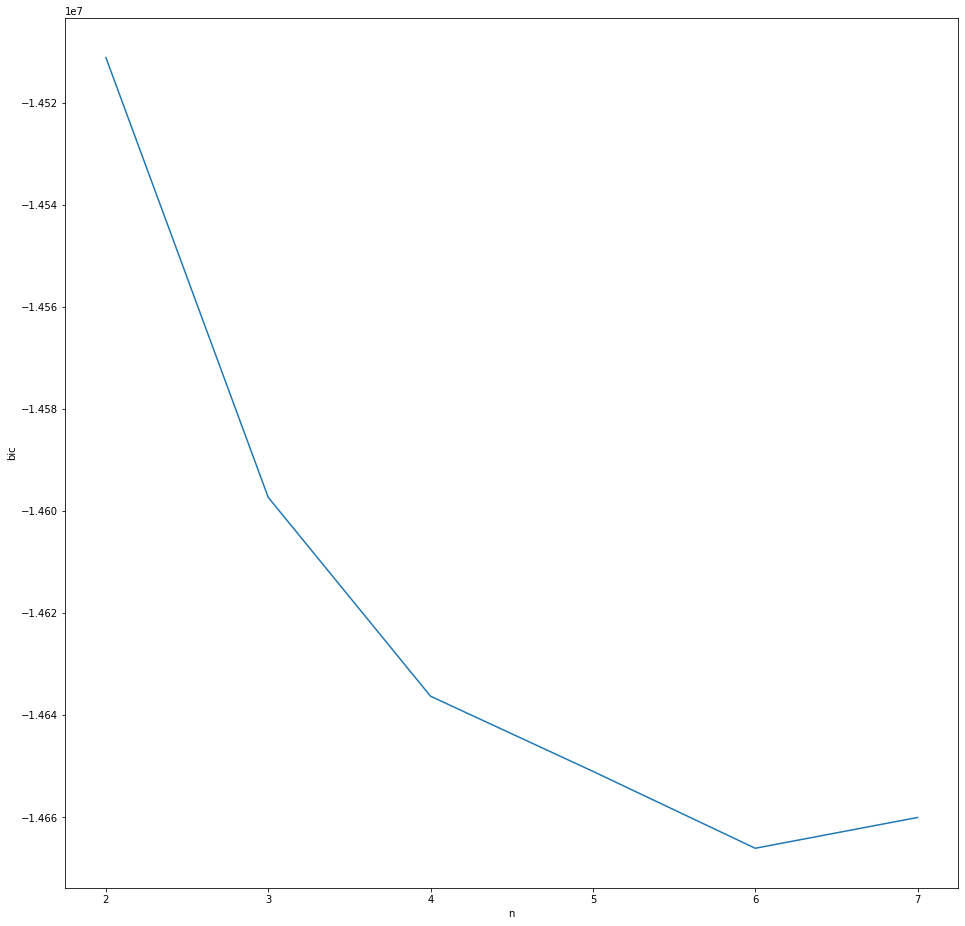

In [136]:
fig, ax = plt.subplots(figsize=(16, 16))
sns.lineplot(ax=ax, x='n', y='bic', data=bic)

In [147]:
n = 6  # illustrative - always base the number on a reasonable estimation of the optimal number of components
n_init = 6  # more initialization, more stable clustering gets

gmm = GaussianMixture(n_components=n, covariance_type="full", max_iter=200, n_init=n_init, verbose=1)
fitted = gmm.fit(data)

Initialization 0
  Iteration 10
  Iteration 20
Initialization converged: True
Initialization 1
  Iteration 10
  Iteration 20
  Iteration 30
  Iteration 40
Initialization converged: True
Initialization 2
  Iteration 10
  Iteration 20
  Iteration 30
  Iteration 40
Initialization converged: True
Initialization 3
  Iteration 10
  Iteration 20
Initialization converged: True
Initialization 4
  Iteration 10
  Iteration 20
  Iteration 30
  Iteration 40
Initialization converged: True
Initialization 5
  Iteration 10
  Iteration 20
  Iteration 30
Initialization converged: True


In [148]:
labels = gmm.predict(data)

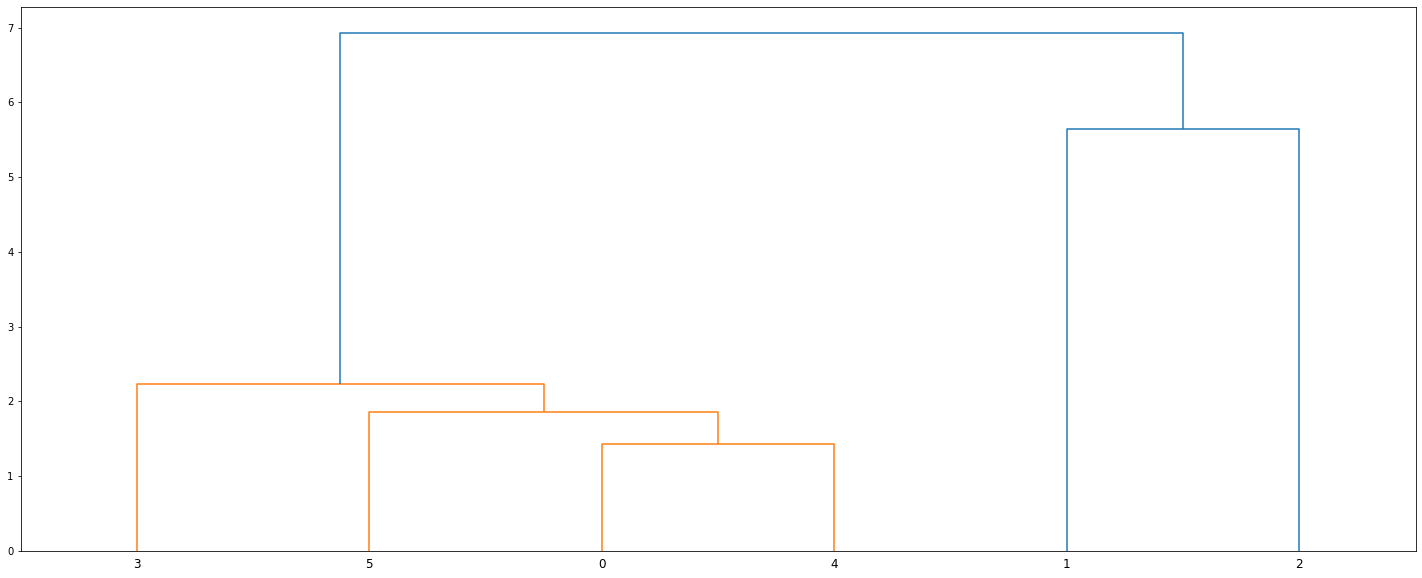

In [149]:
group = data.groupby(labels).mean()
Z = hierarchy.linkage(group, 'ward')
plt.figure(figsize=(25, 10))
dn = hierarchy.dendrogram(Z, labels=group.index)


(181000.0, 181800.0)

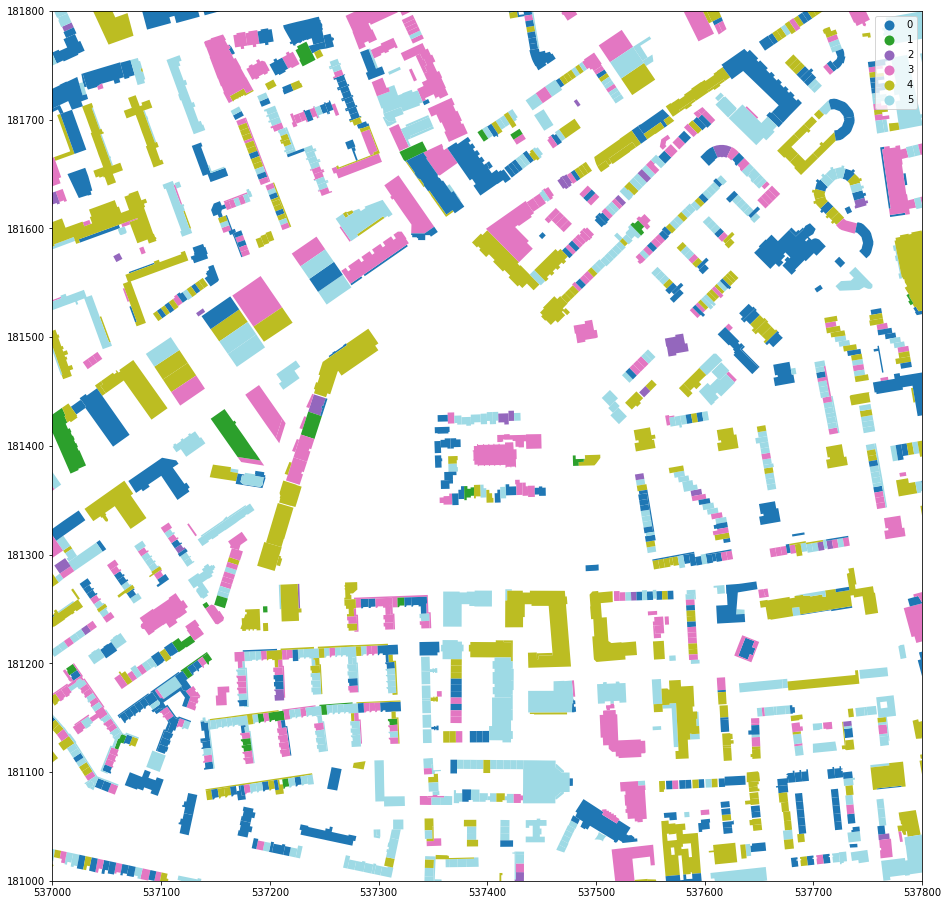

In [150]:
f, ax = plt.subplots(figsize=(16, 16))
buildings.plot(labels, ax=ax, categorical=True, cmap='tab20', legend=True, figsize=(16, 16))
ax.set_xlim(537000, 537800)
ax.set_ylim(181000, 181800)

In [ ]:
#DONOT RUN
1=
buildings['sdbAre'] = mm.Area(buildings).series
buildings['sdbVol'] = mm.Volume(buildings, 'height', 'sdbAre').series
buildings['sdbPer'] = mm.Perimeter(buildings).series
buildings['sdbCoA'] = mm.CourtyardArea(buildings, 'sdbAre').series
buildings['ssbFoF'] = mm.FormFactor(buildings, 'sdbVol', 'sdbAre', heights="height").series
buildings['ssbVFR'] = mm.VolumeFacadeRatio(buildings, 'height', 'sdbVol', 'sdbPer').series
buildings['ssbCCo'] = mm.CircularCompactness(buildings, 'sdbAre').series
buildings['ssbCor'] = mm.Corners(buildings, verbose=False).series
buildings['ssbSqu'] = mm.Squareness(buildings, verbose=False).series

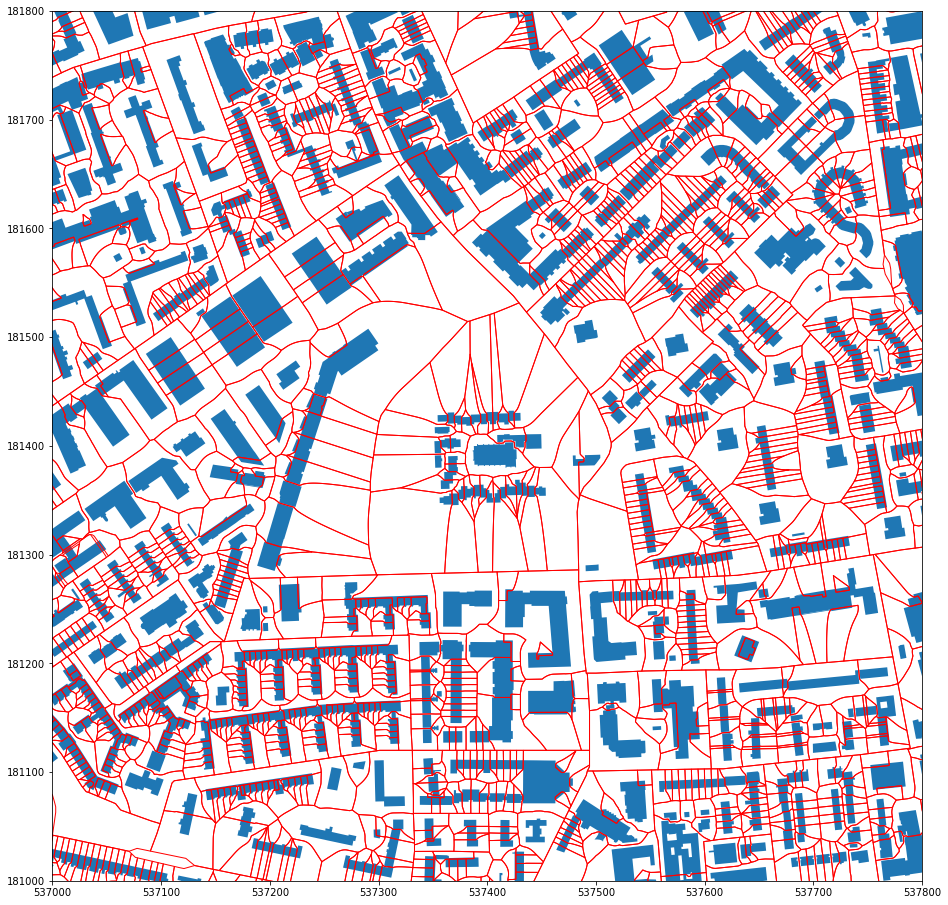

In [172]:
f, ax = plt.subplots(figsize=(16, 16))
col = 'ssbSqu'
buildings.plot(ax=ax, legend=True, scheme='quantiles', k=6, zorder=1)
tessellation.plot(facecolor="none", edgecolor='r',linewidth = 1,ax=ax, zorder=2)
ax.set_xlim(537000, 537800)
ax.set_ylim(181000, 181800)

plt.savefig('plot/' + col + '.png')
plt.show()